In [2]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [3]:
print(os.listdir())

['healthy.JPG', 'plant-disease-infer.ipynb', '.ipynb_checkpoints', 'potatoes.h5', 'Frontend', 'potatoes_model', 'plant-disease.ipynb', 'Project Statement.docx', 'potatoes', 'PlantVillage', 'API', 'PlantVillage (copy)']


In [4]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 25
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "./PlantVillage (copy)"
depth=3
AUTOTUNE = tf.data.AUTOTUNE


In [5]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = (image / 255.0)
    return image, label

@tf.function
def augment(image, label, seed=123):
    image, label = resize_and_rescale(image, label)
#     image = tf.image.stateless_random_crop(
#         image, size=[IMAGE_SIZE, IMAGE_SIZE, 3],
#         seed=seed
#     )
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5,
        seed=seed
    )
    image = tf.clip_by_value(image, 0, 1)
    return image, label


In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

class_names = dataset.class_names
print(class_names)
n_classes = len(class_names)

# dataset = (
#     dataset
#     .shuffle(1000)
#     .map(augment, num_parallel_calls=AUTOTUNE)
#     .batch(batch_size)
#     .prefetch(AUTOTUNE)
# )


Found 2152 files belonging to 3 classes.
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


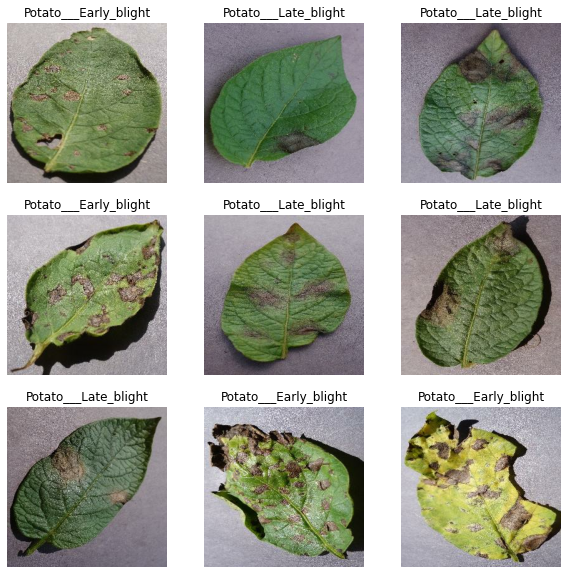

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


In [10]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [13]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (depth, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [24]:
model = models.Sequential()
model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64,  kernel_size = (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64,  kernel_size = (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))
model.build(input_shape=(32,256,256,3))

In [25]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
EPOCHS = 50
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/50
54/54 [==============================] - 3s 42ms/step - loss: 0.8931 - accuracy: 0.5082 - val_loss: 0.8447 - val_accuracy: 0.5104
Epoch 2/50
54/54 [==============================] - 2s 41ms/step - loss: 0.6702 - accuracy: 0.6802 - val_loss: 0.3514 - val_accuracy: 0.8906
Epoch 3/50
54/54 [==============================] - 2s 40ms/step - loss: 0.5379 - accuracy: 0.7612 - val_loss: 0.3478 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 2s 40ms/step - loss: 0.3962 - accuracy: 0.8351 - val_loss: 0.2574 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 2s 40ms/step - loss: 0.3102 - accuracy: 0.8627 - val_loss: 0.2889 - val_accuracy: 0.8646
Epoch 6/50
54/54 [==============================] - 2s 41ms/step - loss: 0.2996 - accuracy: 0.8680 - val_loss: 0.2616 - val_accuracy: 0.8646
Epoch 7/50
54/54 [==============================] - 2s 41ms/step - loss: 0.2772 - accuracy: 0.8797 - val_loss: 0.1782 - val_accuracy: 0.9219
Epoch 8/50
54

In [28]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 1s 14ms/step - loss: 0.0048 - accuracy: 0.9957
Test Accuracy: 99.57000000000001%


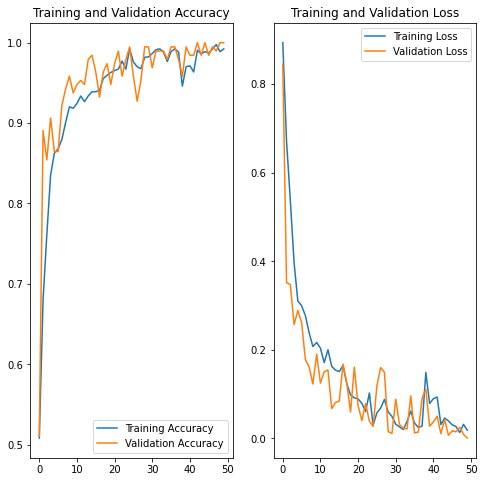

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [30]:
model.save("potatoes.h5")
model.save("potatoes")

INFO:tensorflow:Assets written to: potatoes/assets


In [80]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
        
    predicted_class = class_names[np.argmax(score)]
    confidence = round(100 * (np.max(score)), 2)
    return predicted_class, confidence

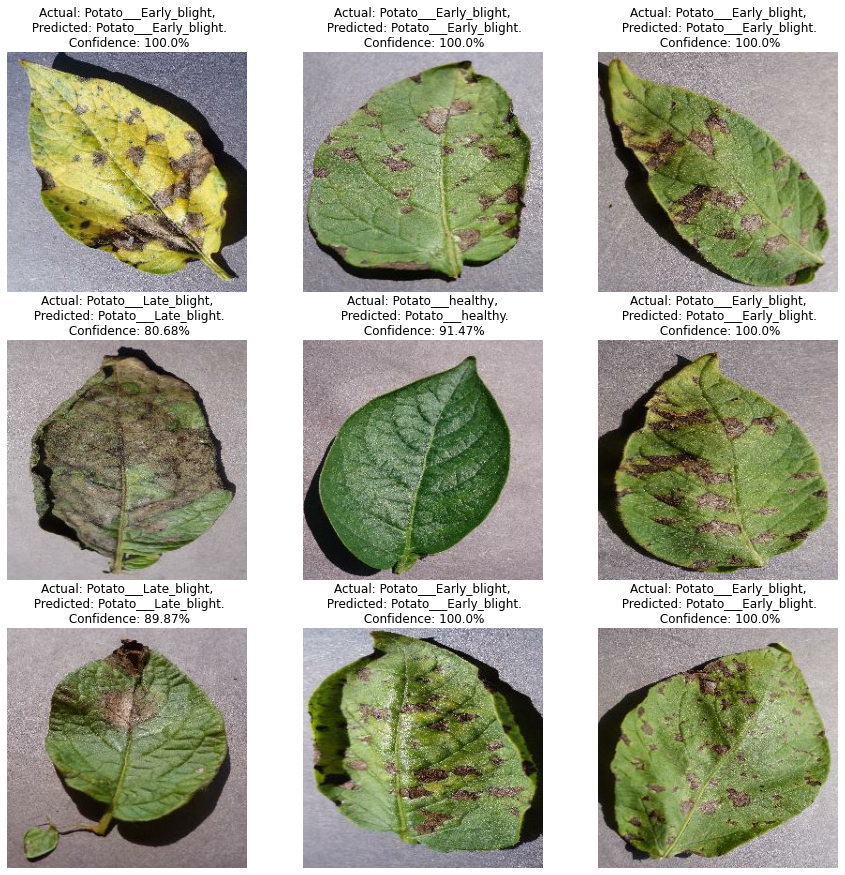

In [90]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [118]:
val_ds.take(1)

<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [91]:
pred = model.predict(test_ds)

In [93]:
pred

array([[2.22047310e+01, 8.55315590e+00, 0.00000000e+00],
       [3.37888908e+01, 1.07980700e+01, 0.00000000e+00],
       [3.14446831e+01, 1.01422920e+01, 0.00000000e+00],
       [2.89088345e+01, 1.21695242e+01, 0.00000000e+00],
       [5.33920956e+00, 1.41080122e+01, 1.46919990e+00],
       [2.14159737e+01, 4.99676466e+00, 0.00000000e+00],
       [2.88069153e+01, 1.40813456e+01, 0.00000000e+00],
       [1.85035336e+00, 9.05091667e+00, 1.53847492e+00],
       [4.57480240e+00, 1.62837772e+01, 1.95315957e+00],
       [8.15981197e+00, 1.17468624e+01, 0.00000000e+00],
       [2.01527538e+01, 5.09142351e+00, 0.00000000e+00],
       [2.48792229e+01, 6.53778839e+00, 0.00000000e+00],
       [3.23792496e+01, 9.12380409e+00, 0.00000000e+00],
       [2.51875896e+01, 6.21564484e+00, 0.00000000e+00],
       [2.09303951e+00, 1.32214441e+01, 3.45020318e+00],
       [2.46416473e+01, 7.95480537e+00, 0.00000000e+00],
       [4.50375700e+00, 1.35833454e+01, 8.01556528e-01],
       [2.12058563e+01, 5.73599

In [126]:
array = []
for i in test_ds.as_numpy_iterator():
    print(i[1])
    break

[0 0 0 0 1 1 0 2 1 0 1 0 0 2 0 2 0 1 2 0 0 0 2 1 0 0 1 1 1 1 0 2]
